# Initial Exploration

## Problem description

Let f(x, P) be a neural network with fixed structure that takes as input a feature vector x and computes a real-valued output based on learnable parameters P.  Suppose that in response to a training example, the parameters are updated to P'.  The difference between the value of the function before and after the update is:

f(x, P) - f(x, P')

We would like a network that generalizes in the neighborhood of x.  That is, if x' is an input vector “close” to x, we would like the change in f due to the change in P at x to be similar in sign and magnitude to the change in f at x' due to the change in P.  The latter quantity can be written:

f(x', P) - f(x', P')

They are similar if the following loss is _all:

L\_gen = ((f(x, P) - f(x, P')) - (f(x', P) - f(x', P'))^2

If I update the parameters from P to P', the change in f should be similar in the neighborhood of x.  As |x - x'| gets larger, the neighborhood of the generalization increases.

Our goal is to pre-train a network using unlabeled data to get into a part of the parameter space such that generalization during pre-training is broad, thereby leading to faster convergence.  Consider the following algorithmic approach to this idea.


```
Input: X = {x1, x2, , xn}, neural network f, x, P
x is the standard deviation of the noise applied to x
p is the standard deviation of the noise applied to P

While not converged
  Choose x from X at random
  x’ = x + N(0, x)
  P’ = P + N(0, P)
  Compute derivative of  Lgen wrt P
  Update P using gradient descent

Return P
```gradient descent

Return P


In [1]:
import math

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import copy

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import Generator
from torchvision.datasets import MNIST

In [2]:
class TinyModel(nn.Module):

    def __init__(self):
        super(TinyModel, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(1, 10),
            nn.ELU(),
            nn.Linear(10, 30),
            nn.ELU(),
            nn.Linear(30, 10),
            nn.ELU(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [3]:
class FunctionDataset(Dataset):
    
    def __init__(self, function, num_samples, start=0, stop=2*math.pi, rand_pts=False, noise=0):
        self.num_samples = num_samples
        self.start = start
        self.stop = start
        self.noise = noise

        if not rand_pts:
            pts = np.linspace(start, stop, num_samples)
            self.data = torch.from_numpy(pts).to(torch.float32)
        else:
            self.data = torch.sort(torch.zeros((num_samples,), dtype=torch.float32).uniform_(start, stop))
        
        self.labels = function(self.data).to(torch.float32)
        self.labels = self.labels + torch.normal(0, noise,  self.labels.shape)
        
    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        label = self.labels[idx]
        return self.data[idx], label

    def get_data(self):
        return self.data

    def get_labels(self):
        return self.labels
        

In [4]:
# For all data loaders, use a generator that copies the state of this one
base_gen = Generator()
base_gen.seed()

11732157610799040667

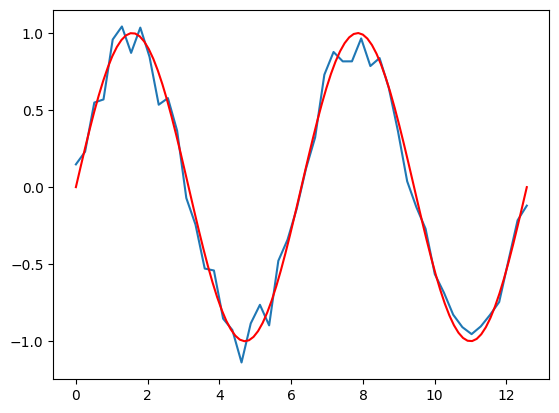

In [5]:
train_noise = 0.1

train_data = FunctionDataset(torch.sin, 50, stop=4*math.pi, noise=train_noise)
test_data = FunctionDataset(torch.sin, 100, stop=4*math.pi, rand_pts=False)
plt.plot(train_data.get_data().numpy(), train_data.get_labels().numpy())
plt.plot(test_data.get_data().numpy(), test_data.get_labels().numpy(), color='red')


train_gen = Generator().set_state(base_gen.get_state())
train_dataloader = DataLoader(train_data, batch_size=1, shuffle=True, generator=train_gen)

test_gen = Generator().set_state(base_gen.get_state())
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True, generator=test_gen)

In [6]:
learning_rate = 1e-2
epochs = 200

# all models should have the same initial weights
sin_model = TinyModel()
precond_model = copy.deepcopy(sin_model)
jittered_model = copy.deepcopy(sin_model)
# would fixing torch.random_seed() here allow 
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(sin_model.parameters(), lr=learning_rate)

In [7]:
# Taken from https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html and somewhat altered
def train_loop(dataloader, model, loss_fn, optimizer, jitter=0):
    size = len(dataloader.dataset)
    total_loss = 0
    batches = 0
    
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X + torch.normal(0, jitter, X.shape))
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
        batches += 1
        
    return total_loss / batches

def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    xs = []
    ys = []
    preds = []
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            xs.append(X.item())
            preds.append(pred.item())
            ys.append(y.item())
            test_loss += loss_fn(pred, y).item()

    plt.scatter(xs, ys, label="True points")
    plt.scatter(xs, preds, label="Predictions")
    plt.legend()

    plt.show()
    test_loss /= num_batches
    print(f"Avg loss: {test_loss:>8f} \n")
    return test_loss

In [8]:
# Based off Mohammad M's initial code sample
def nbd_loss(a, b, c, d):
    return torch.sum(((a-b) - (c-d))**2)

def precond_loop(network, network_prime, dataloader, four_loss, optimizer, x_std=.15, p_stds=[0.15, .05, .025, .05]):
    total_loss = 0
    for batch, (X, y) in enumerate(dataloader):

        optimizer.zero_grad()
        x_prime = X + torch.normal(0, x_std, X.shape)
        
        param_prime = {}
        for i, (name, p) in enumerate(network.state_dict().items()):
            param_prime[name] = p.clone() + torch.zeros_like(p).uniform_(0, p_stds[i//2])
            param_prime[name].requires_grad = False
        network_prime.load_state_dict(param_prime)

        # forward 1: f(x, p)
        y_x_p = network(X)
        # forward 2: f(x', p)
        y_xp_p = network(x_prime)
        # forward 3: f(x, p')
        y_x_pp = network_prime(X)
        # forward 4: f(x', p')
        y_xp_pp = network_prime(x_prime)
        
        loss = four_loss(y_x_p, y_x_pp, y_xp_p, y_xp_pp)
        """
        if batch < 10 or batch > len(dataloader) - 10:
            print("Batch: ", batch)
            print("f(x, p): ", y_x_p.item())
            print("f(x', p): ", y_xp_p.item())
            print("f(x, p'): ", y_x_pp.item())
            print("f(x', p'): ", y_xp_pp.item())
            print()
        """
        # backward: calculating the gradients w.r.t. p. Gradients of p' is turned off in line 44
        loss.backward()
        # update weights
        optimizer.step()
        total_loss += loss.item()
    return total_loss / batch

def model_residual_F(model_a: torch.nn.Module, model_b: torch.nn.Module):
    # assumes model_a and model_b have the same shape & weights
    with torch.no_grad():
        a_dict = model_a.state_dict()
        
        b_dict = model_b.state_dict() if model_b is not None else None
        total = 0
        for param_name in a_dict.keys():
            if b_dict is not None:
                partial_resid = a_dict[param_name] - b_dict[param_name]
                partial_resid = partial_resid ** 2
            else:
                partial_resid = a_dict[param_name] ** 2
            total += torch.sum(partial_resid).item()
    
        return total ** 0.5

Epoch: 1


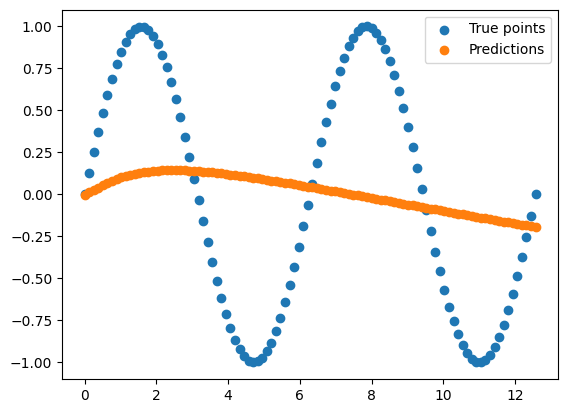

Avg loss: 0.462214 

Epoch: 2


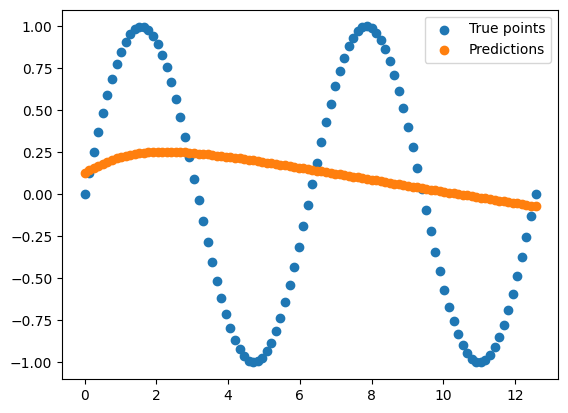

Avg loss: 0.475637 

Epoch: 3


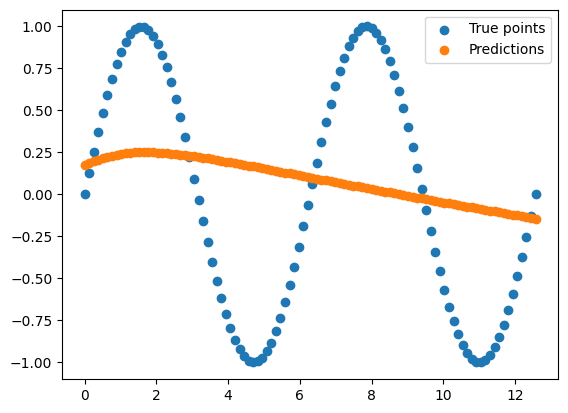

Avg loss: 0.456040 

Epoch: 4


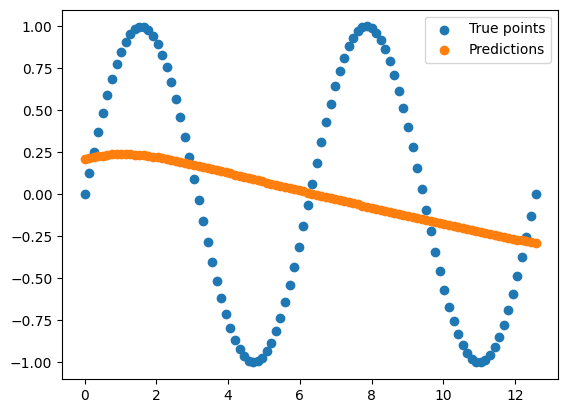

Avg loss: 0.434819 

Epoch: 5


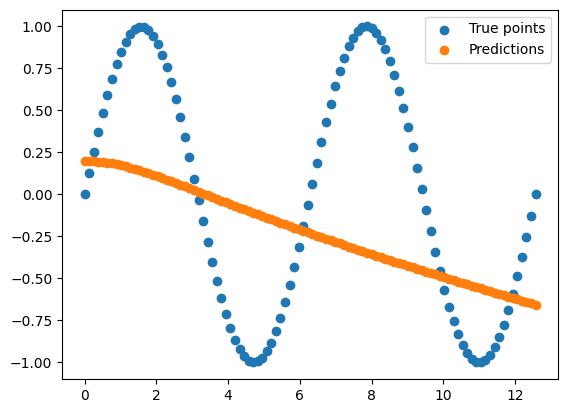

Avg loss: 0.470564 

Epoch: 6


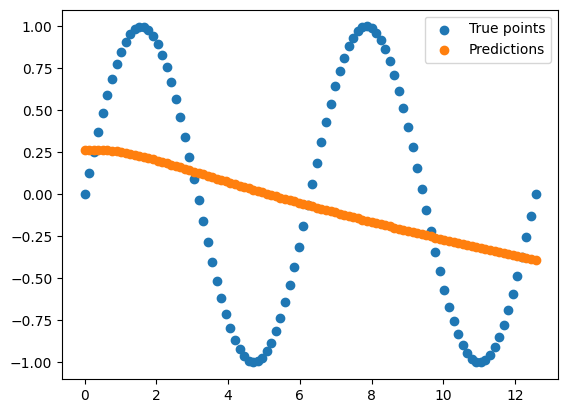

Avg loss: 0.429114 

Epoch: 7


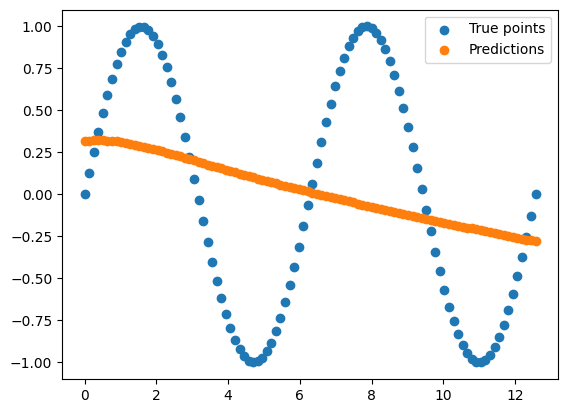

Avg loss: 0.428763 

Epoch: 8


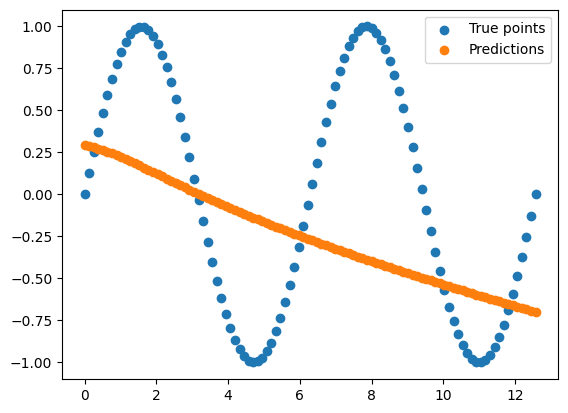

Avg loss: 0.477430 

Epoch: 9


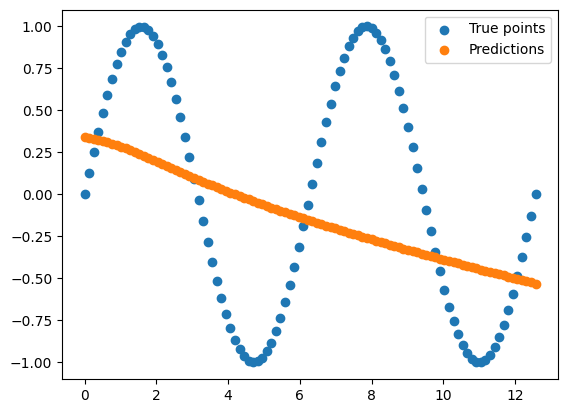

Avg loss: 0.435410 

Epoch: 10


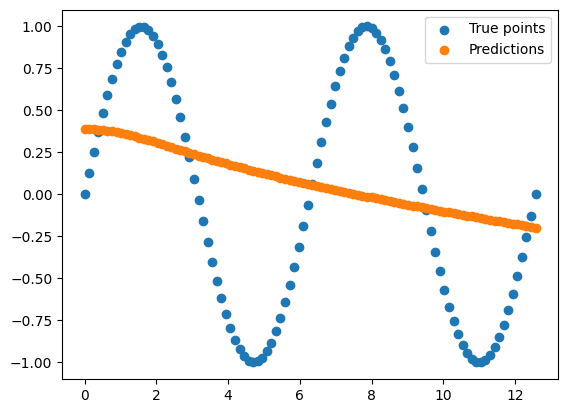

Avg loss: 0.434305 

Epoch: 11


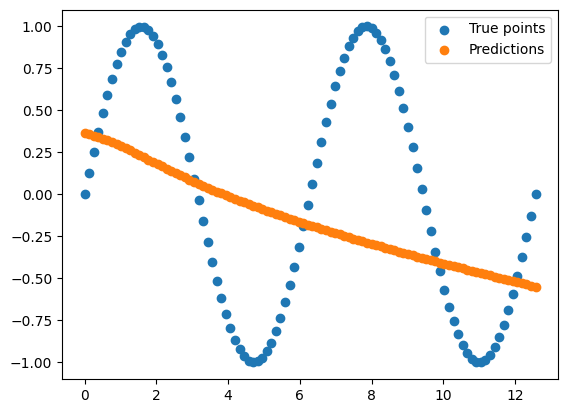

Avg loss: 0.439316 

Epoch: 12


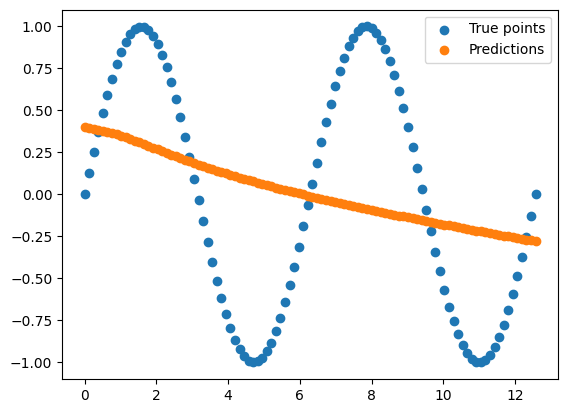

Avg loss: 0.423501 

Epoch: 13


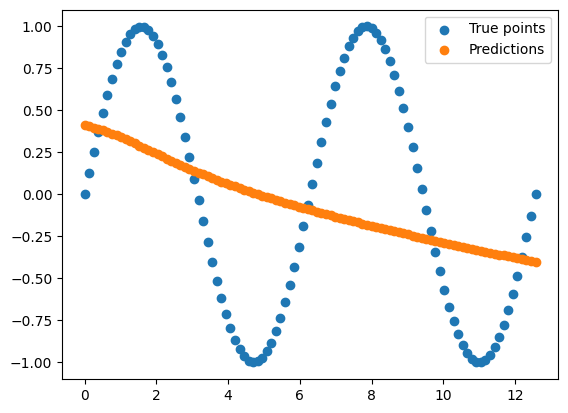

Avg loss: 0.421207 

Epoch: 14


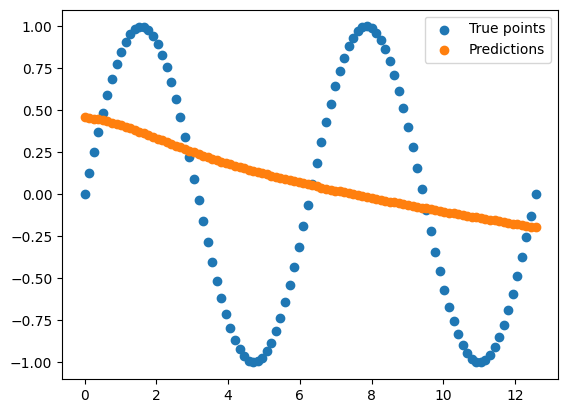

Avg loss: 0.431445 

Epoch: 15


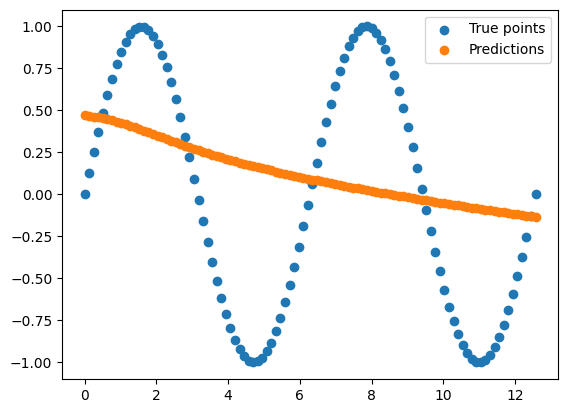

Avg loss: 0.441245 

Epoch: 40


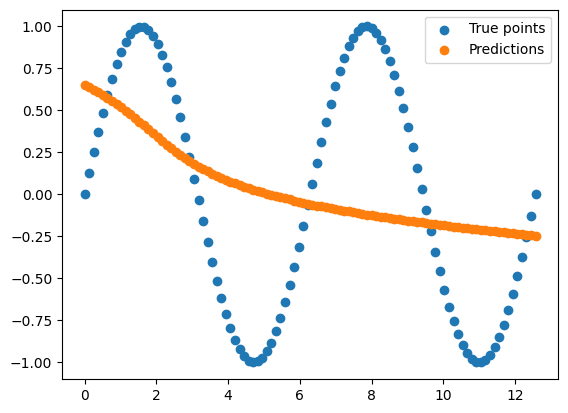

Avg loss: 0.411313 

Epoch: 80


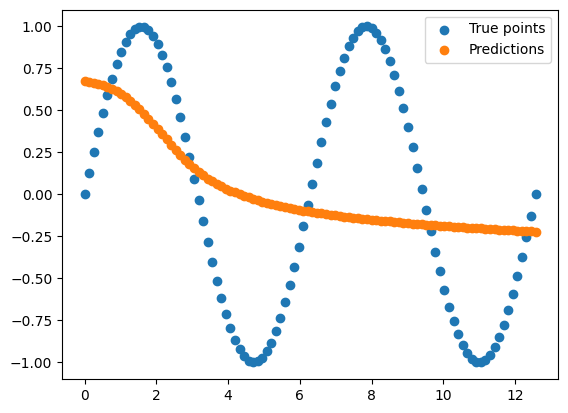

Avg loss: 0.400640 

Epoch: 120


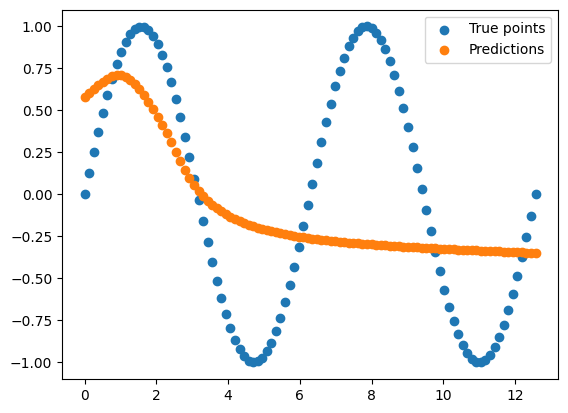

Avg loss: 0.386528 

Epoch: 160


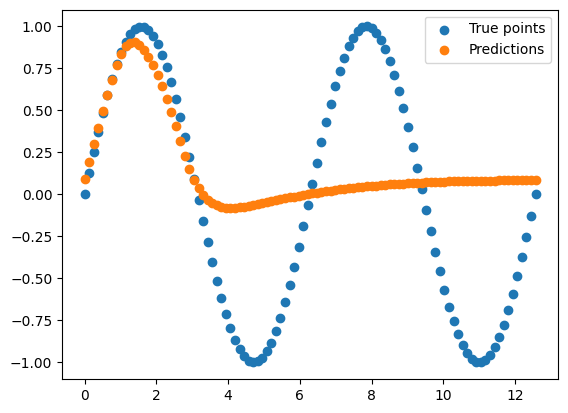

Avg loss: 0.371677 

Epoch: 200


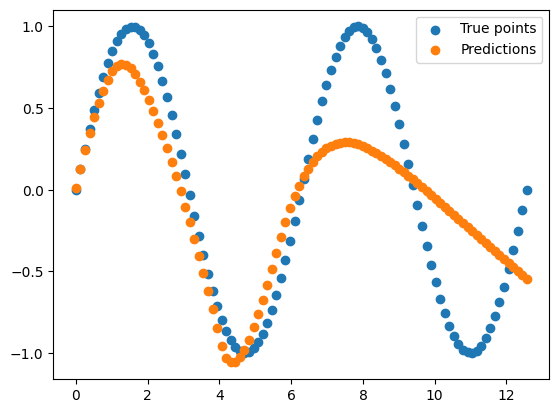

Avg loss: 0.151247 

Done!


In [9]:
standard_train_losses = []

for t in range(epochs):
    
    standard_train_losses.append(train_loop(train_dataloader, sin_model, loss_function, optimizer))
    if (t + 1) < 16 or (t+1) % int(.2 * epochs) == 0:
        print(f"Epoch: {t+1}")
        test_loop(test_dataloader, sin_model, loss_function)
print("Done!")

In [10]:
# Pretraining:
precond_epochs = 1000
precond_prime = TinyModel()

precond_lr = 1e-2
precond_optimizer = torch.optim.SGD(precond_model.parameters(), lr=precond_lr)

precond_losses = []
precond_training_losses = []

pre_train_gen = Generator().set_state(base_gen.get_state())
train_dataloader = DataLoader(train_data, batch_size=1, shuffle=True, generator=pre_train_gen)

pre_test_gen = Generator().set_state(base_gen.get_state())
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True, generator=pre_test_gen)

Epoch: 1


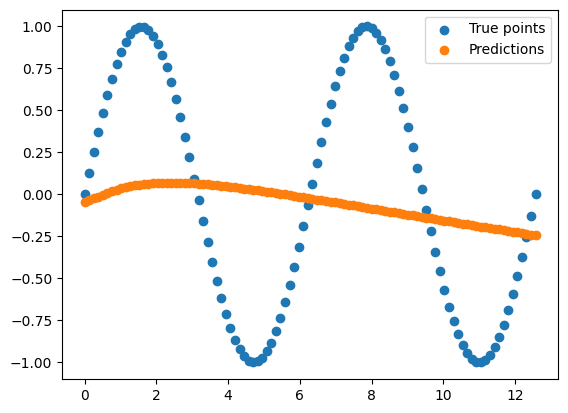

Avg loss: 0.465107 

Epoch: 2


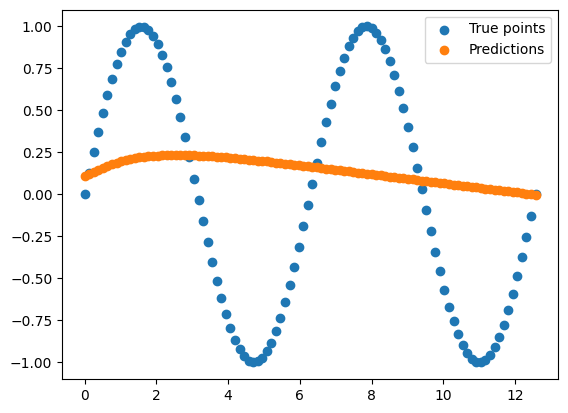

Avg loss: 0.491528 

Epoch: 3


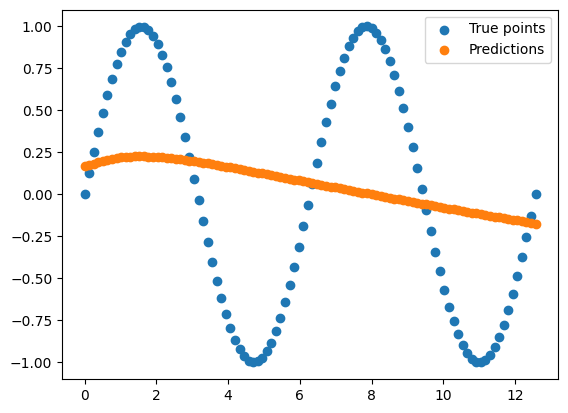

Avg loss: 0.450520 

Epoch: 4


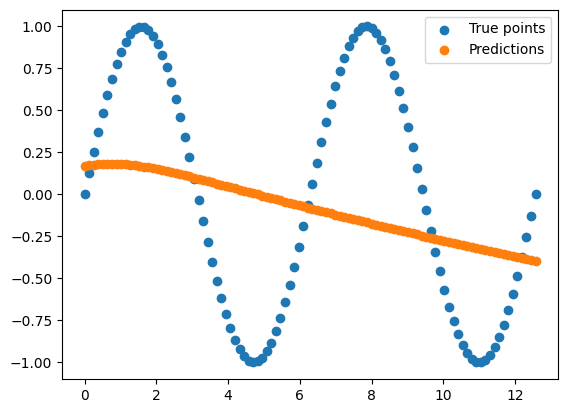

Avg loss: 0.437965 

Epoch: 5


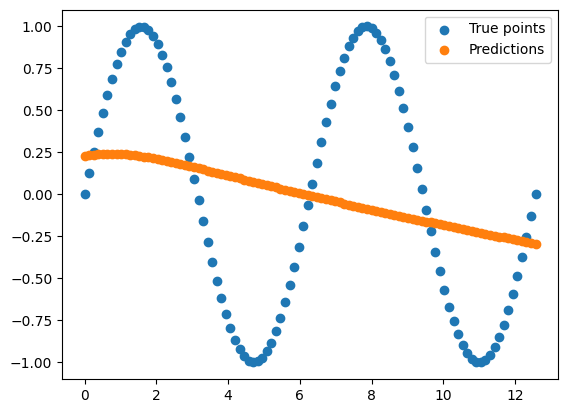

Avg loss: 0.433254 

Epoch: 6


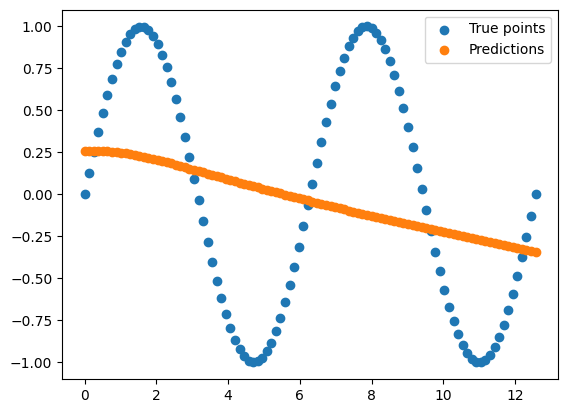

Avg loss: 0.429868 

Epoch: 7


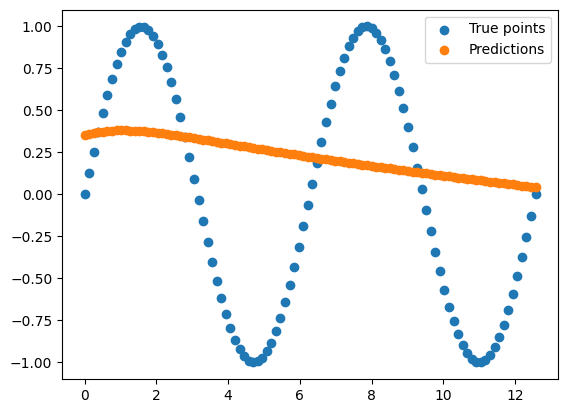

Avg loss: 0.499866 

Epoch: 8


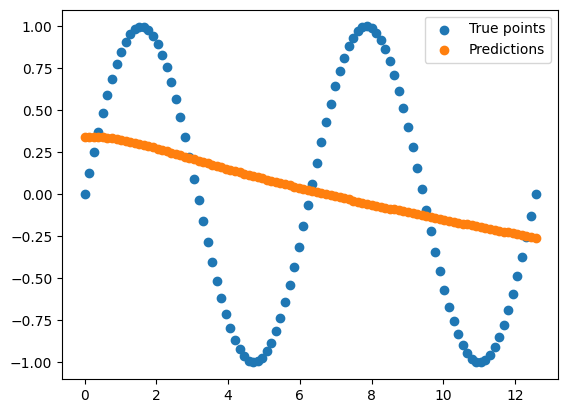

Avg loss: 0.429444 

Epoch: 9


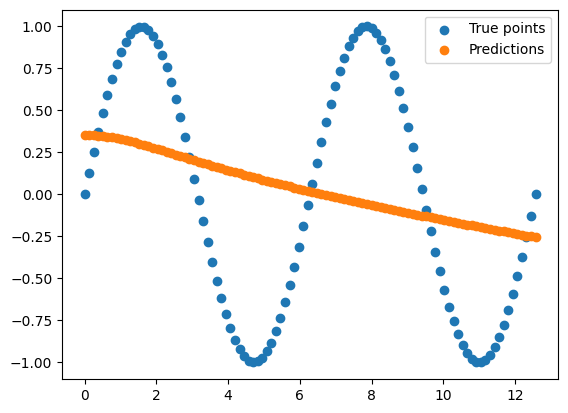

Avg loss: 0.428522 

Epoch: 10


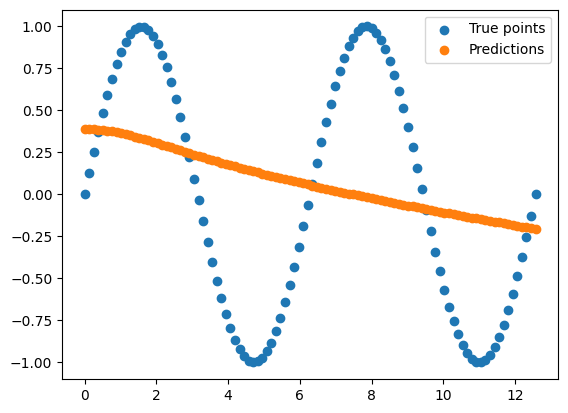

Avg loss: 0.433467 

Epoch: 11


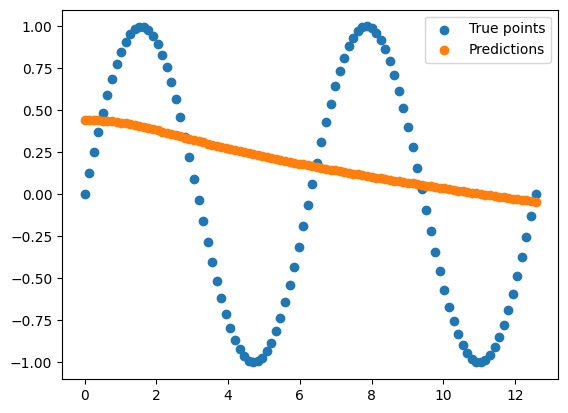

Avg loss: 0.469771 

Epoch: 12


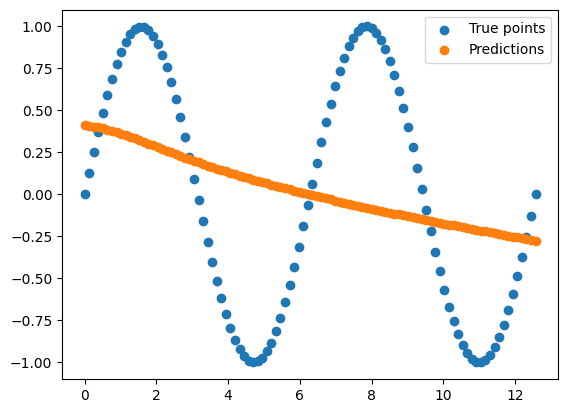

Avg loss: 0.423698 

Epoch: 13


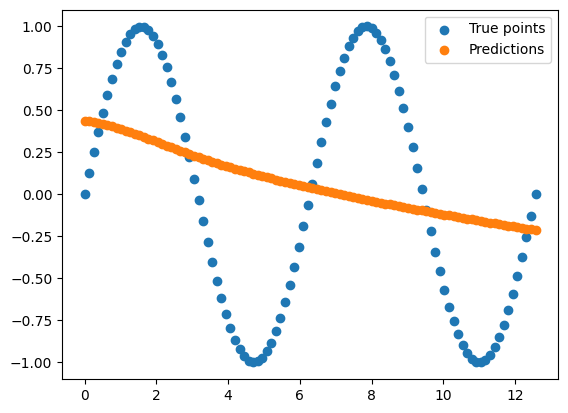

Avg loss: 0.429168 

Epoch: 14


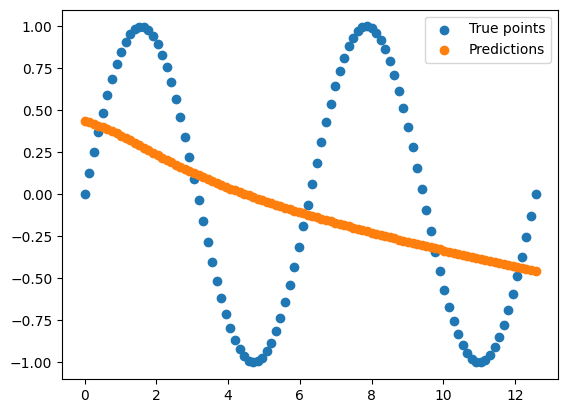

Avg loss: 0.423442 

Epoch: 15


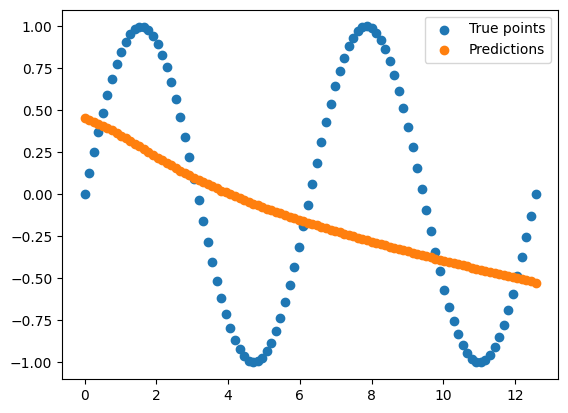

Avg loss: 0.430845 

Epoch: 40


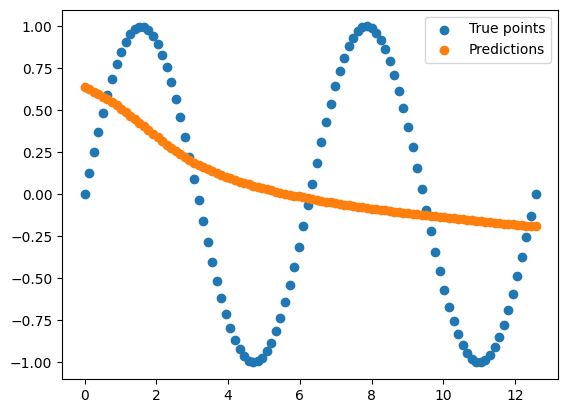

Avg loss: 0.415877 

Epoch: 80


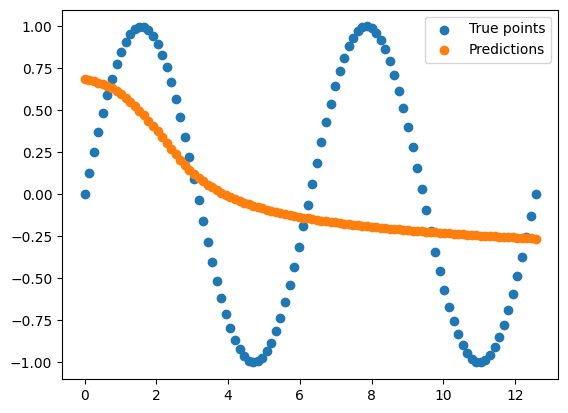

Avg loss: 0.399008 

Epoch: 120


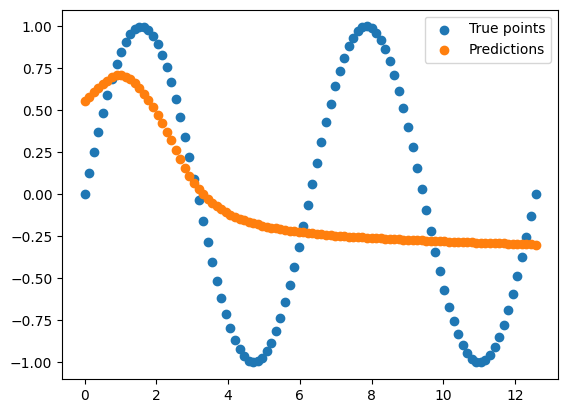

Avg loss: 0.379567 

Epoch: 160


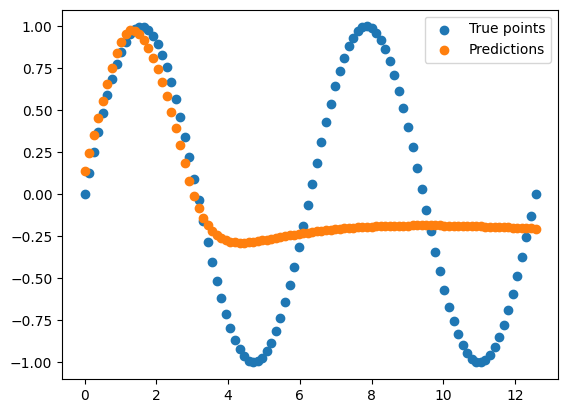

Avg loss: 0.327311 

Epoch: 200


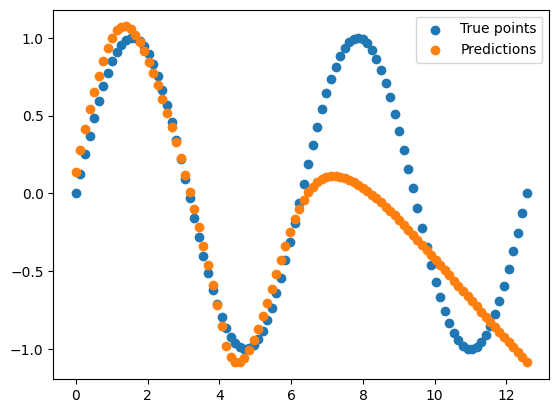

Avg loss: 0.168463 

Done!


In [11]:
original_model = copy.deepcopy(precond_model)

for t in range(precond_epochs):
    precond_losses.append(precond_loop(precond_model, precond_prime, train_dataloader, nbd_loss, precond_optimizer))
    
residual = model_residual_F(precond_model, original_model)

# we will use the same preconditioning to train a model for cosine
cos_precond_model = copy.deepcopy(precond_model)

training_optimizer = torch.optim.SGD(precond_model.parameters(), lr=learning_rate)
for t in range(epochs):
    
    precond_training_losses.append(train_loop(train_dataloader, precond_model, loss_function, training_optimizer))
    if (t + 1) < 16 or (t+1) % int(.2 * epochs) == 0:
        print(f"Epoch: {t+1}")
        test_loop(test_dataloader, precond_model, loss_function)
print("Done!")


In [12]:
print(f"Norm of untrained model:", model_residual_F(original_model, None))
print(f"Norm of trained standard model:", model_residual_F(sin_model, None))
print(f"Norm of trained preconditioned model:", model_residual_F(precond_model, None))
print(f"Residual from preconditioning:", residual)
print(f"Residual between trained models:", model_residual_F(precond_model, sin_model))

Norm of untrained model: 4.734276474660864
Norm of trained standard model: 6.245512798744075
Norm of trained preconditioned model: 6.292020537451523
Residual from preconditioning: 0.1102359765679297
Residual between trained models: 0.47831524800354674


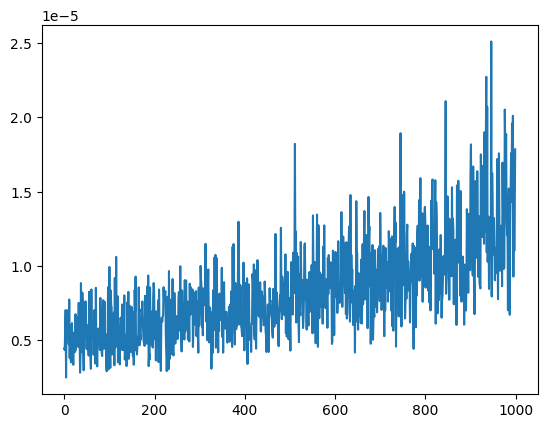

In [13]:
plt.plot(list(range(precond_epochs)), precond_losses)

In [14]:
jitter_std = 0.1

jitter_gen = Generator().set_state(base_gen.get_state())
jitter_train_loader = DataLoader(train_data, shuffle=True, generator=jitter_gen)

test_gen = Generator().set_state(base_gen.get_state())
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True, generator=test_gen)

loss_function = nn.MSELoss()
jitter_optimizer = torch.optim.SGD(jittered_model.parameters(), lr=learning_rate)

jitter_train_losses = []

for t in range(epochs):
    #jitter_train_losses.append(train_loop(jitter_train_loader, jittered_model, loss_function, jitter_optimizer, jitter=jitter_std))
    if (t + 1) < 16 or (t+1) % int(.2 * epochs) == 0:
        print(f"Epoch: {t+1}")
        #test_loop(test_dataloader, jittered_model, loss_function)
print("Done!")

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 40
Epoch: 80
Epoch: 120
Epoch: 160
Epoch: 200
Done!


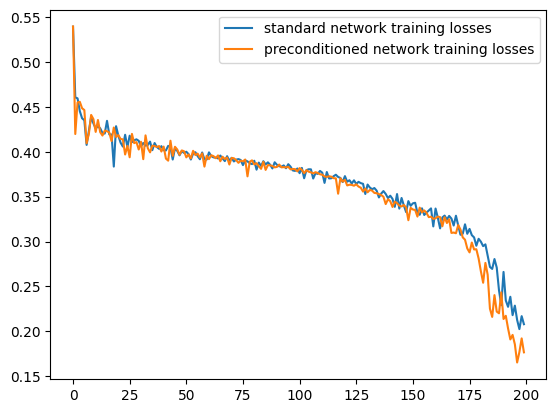

In [15]:
plt.plot(list(range(epochs)), standard_train_losses, label="standard network training losses")
plt.plot(list(range(epochs)), precond_training_losses, label="preconditioned network training losses")
#plt.plot(list(range(epochs)), jitter_train_losses, label="jittered training data losses")
plt.legend()

## Using a copy of the same preconditioned network to learn a different function

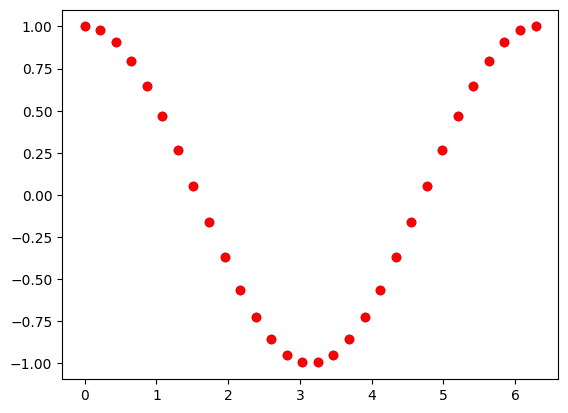

In [16]:
cos_train_data = FunctionDataset(torch.cos, 30)
cos_test_data = FunctionDataset(torch.cos, 30, rand_pts=False)
plt.scatter(cos_train_data.get_data().numpy(), cos_train_data.get_labels().numpy())
plt.scatter(cos_test_data.get_data().numpy(), cos_test_data.get_labels().numpy(), color='red')

cos_train_dataloader = DataLoader(cos_train_data, batch_size=1, shuffle=True)
cos_test_dataloader = DataLoader(cos_test_data, batch_size=1, shuffle=True)


In [17]:
learning_rate = 1e-2
epochs = 200

cos_model = copy.deepcopy(original_model)
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(cos_model.parameters(), lr=learning_rate)

Epoch: 1


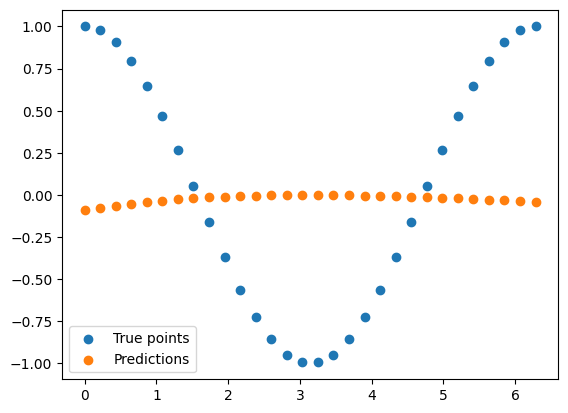

Avg loss: 0.547403 

Epoch: 2


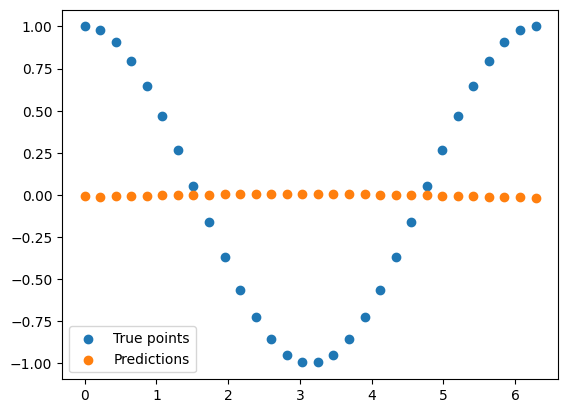

Avg loss: 0.525607 

Epoch: 3


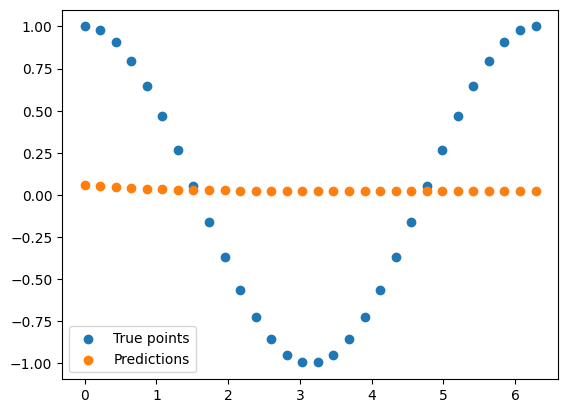

Avg loss: 0.509572 

Epoch: 4


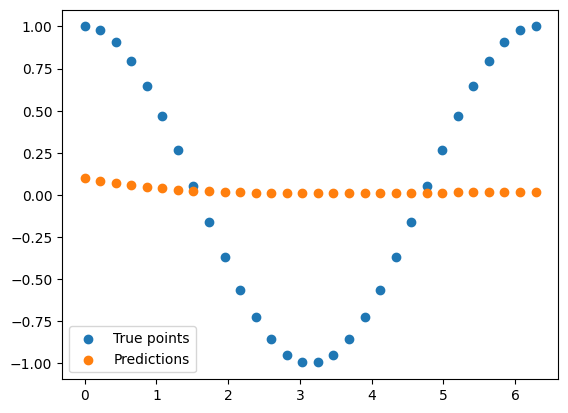

Avg loss: 0.496067 

Epoch: 5


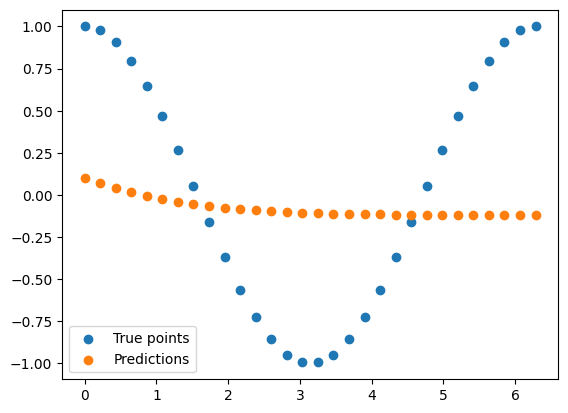

Avg loss: 0.490121 

Epoch: 6


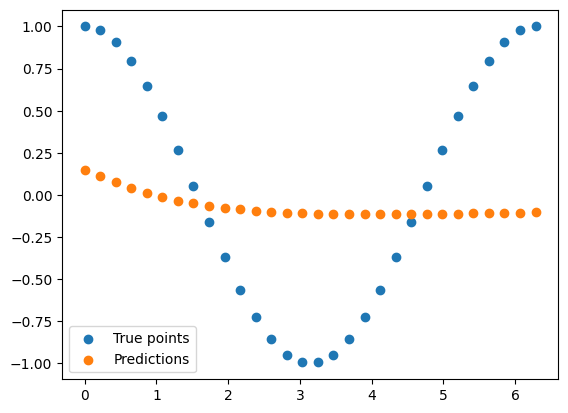

Avg loss: 0.474942 

Epoch: 7


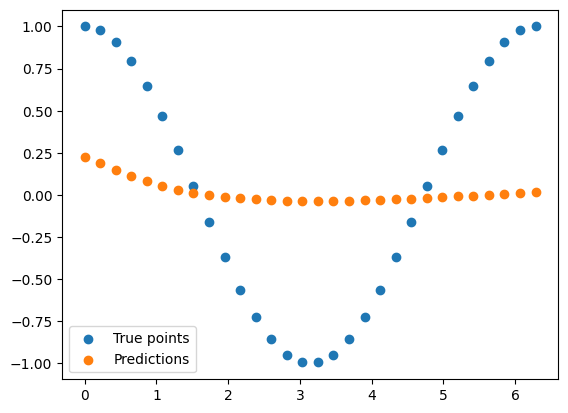

Avg loss: 0.453424 

Epoch: 8


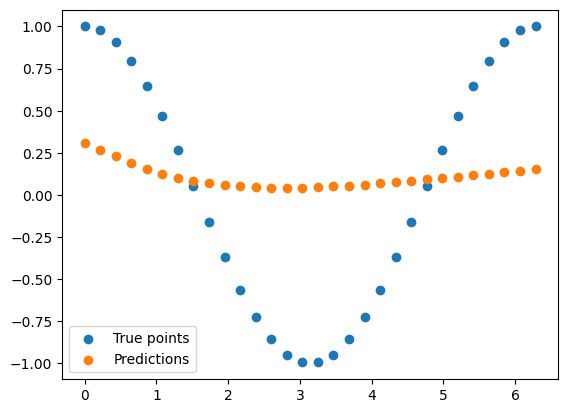

Avg loss: 0.445067 

Epoch: 9


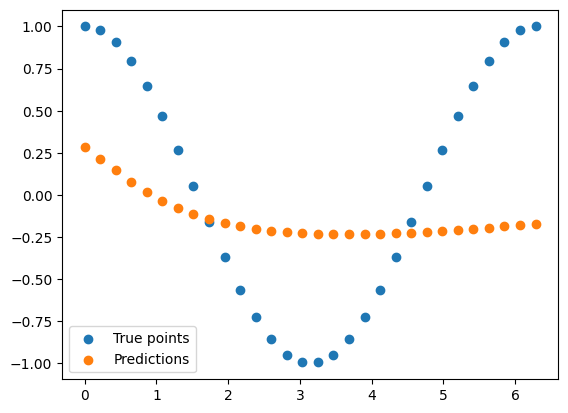

Avg loss: 0.439578 

Epoch: 10


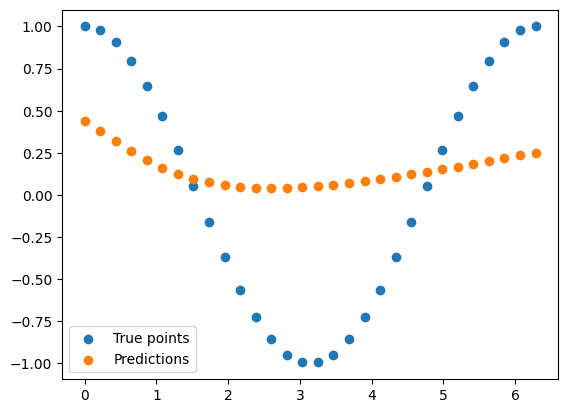

Avg loss: 0.410281 

Epoch: 11


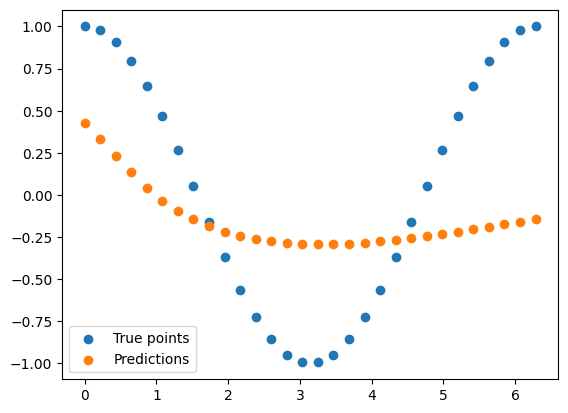

Avg loss: 0.395019 

Epoch: 12


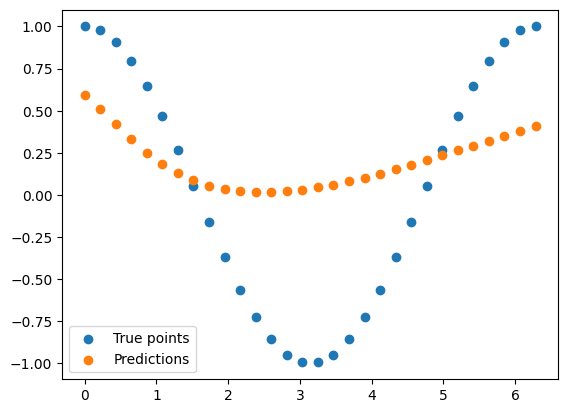

Avg loss: 0.363521 

Epoch: 13


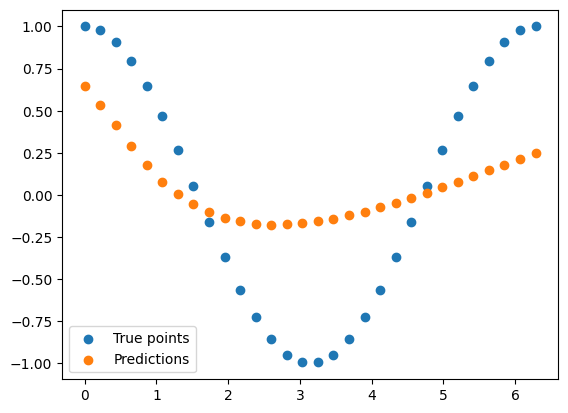

Avg loss: 0.293022 

Epoch: 14


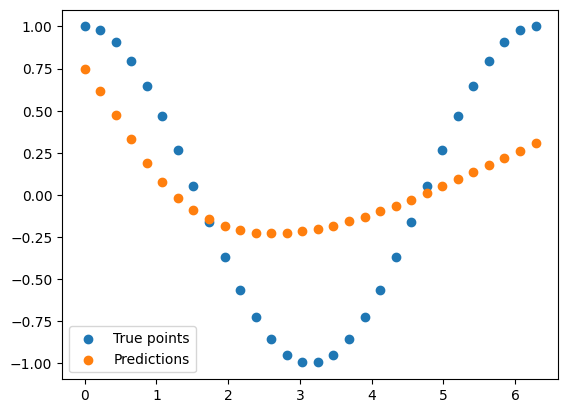

Avg loss: 0.256199 

Epoch: 15


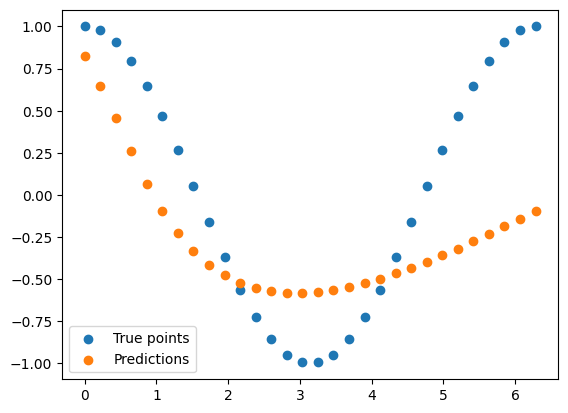

Avg loss: 0.316238 

Epoch: 40


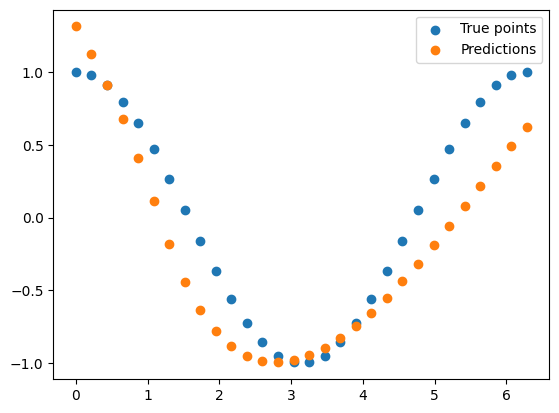

Avg loss: 0.113686 

Epoch: 80


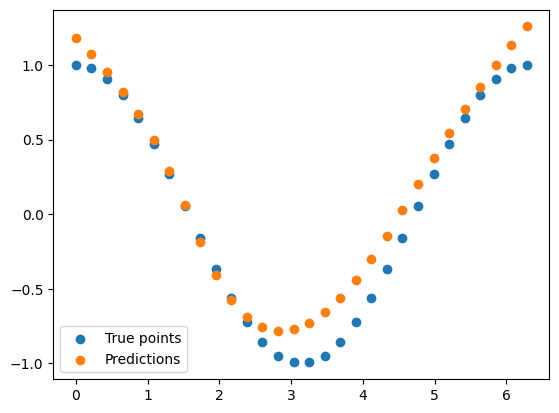

Avg loss: 0.025355 

Epoch: 120


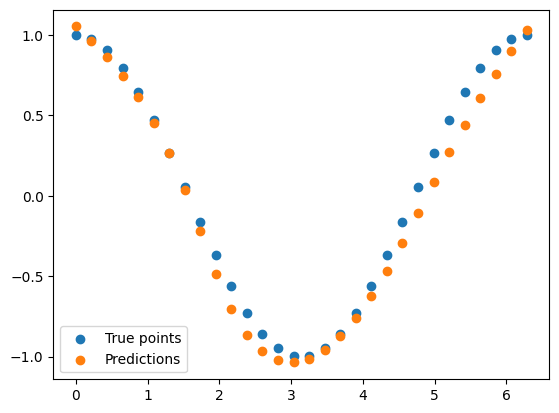

Avg loss: 0.010781 

Epoch: 160


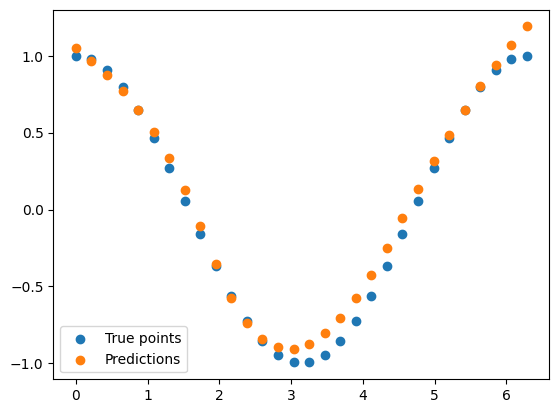

Avg loss: 0.007030 

Epoch: 200


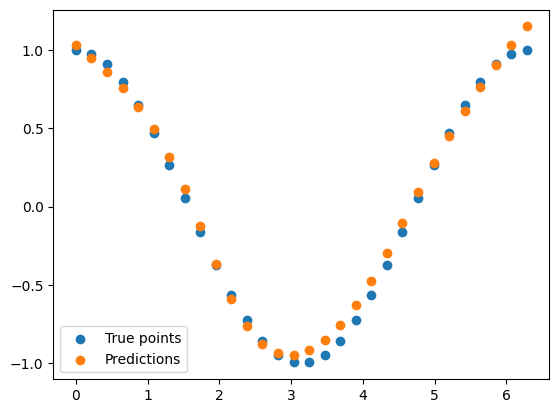

Avg loss: 0.003395 

Done!


In [18]:
cos_standard_train_losses = []

for t in range(epochs):
    #print(f"Epoch {t+1}\n-------------------------------")
    cos_standard_train_losses.append(train_loop(cos_train_dataloader, cos_model, loss_function, optimizer))
    if (t + 1) < 16 or (t+1) % int(.2 * epochs) == 0:
        print(f"Epoch: {t+1}")
        test_loop(cos_test_dataloader, cos_model, loss_function)
print("Done!")

Epoch: 1


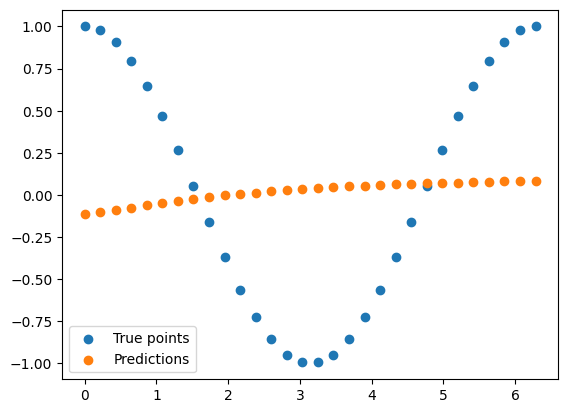

Avg loss: 0.543053 

Epoch: 2


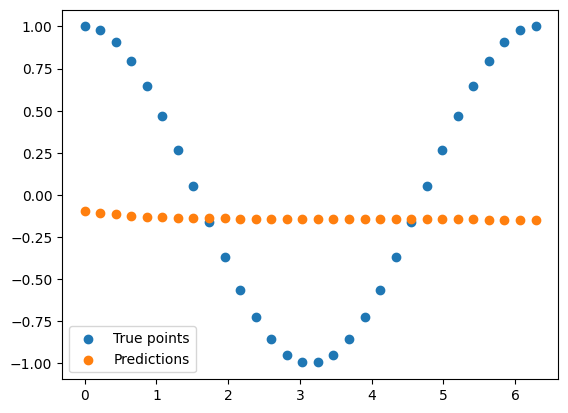

Avg loss: 0.537539 

Epoch: 3


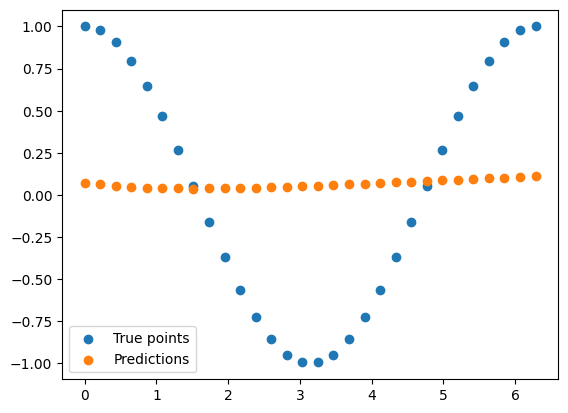

Avg loss: 0.502213 

Epoch: 4


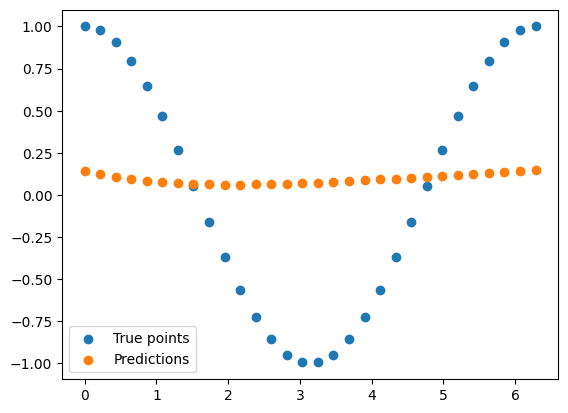

Avg loss: 0.490043 

Epoch: 5


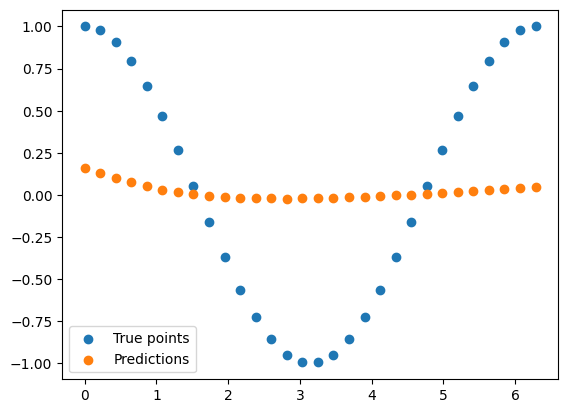

Avg loss: 0.465528 

Epoch: 6


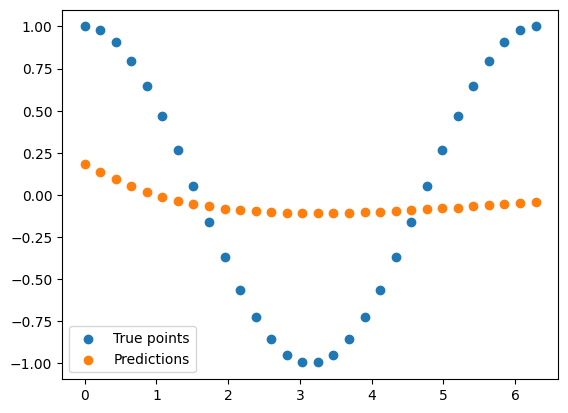

Avg loss: 0.452165 

Epoch: 7


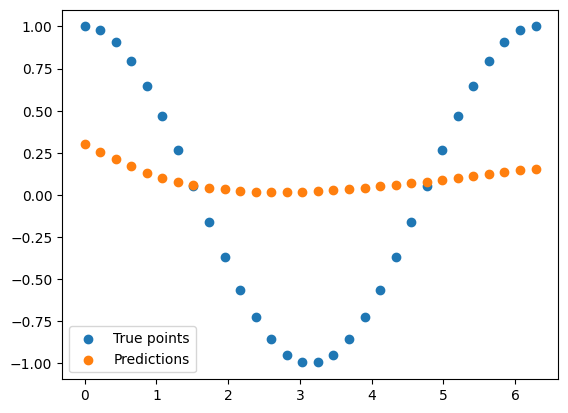

Avg loss: 0.434949 

Epoch: 8


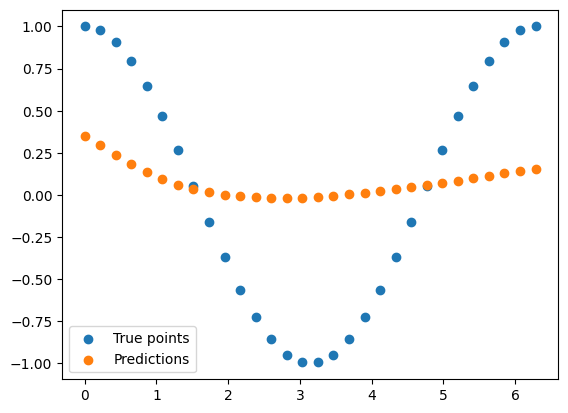

Avg loss: 0.410575 

Epoch: 9


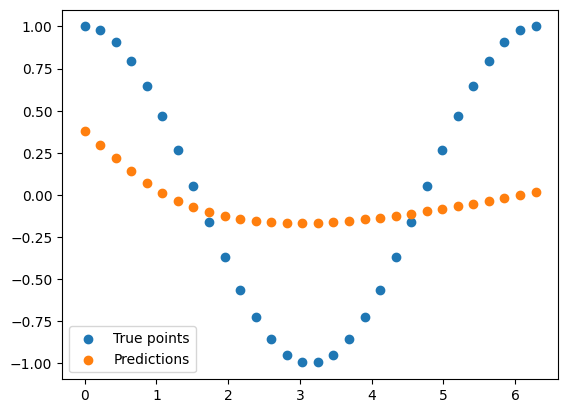

Avg loss: 0.384018 

Epoch: 10


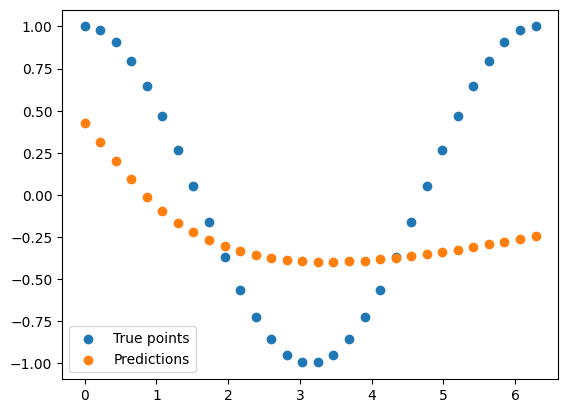

Avg loss: 0.422957 

Epoch: 11


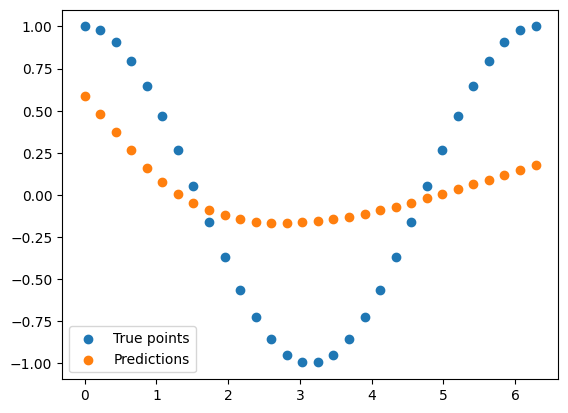

Avg loss: 0.315084 

Epoch: 12


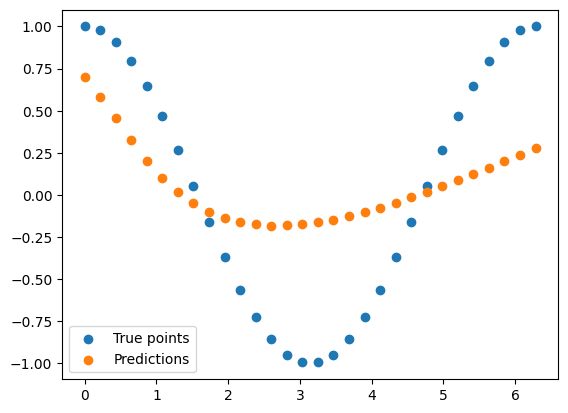

Avg loss: 0.278857 

Epoch: 13


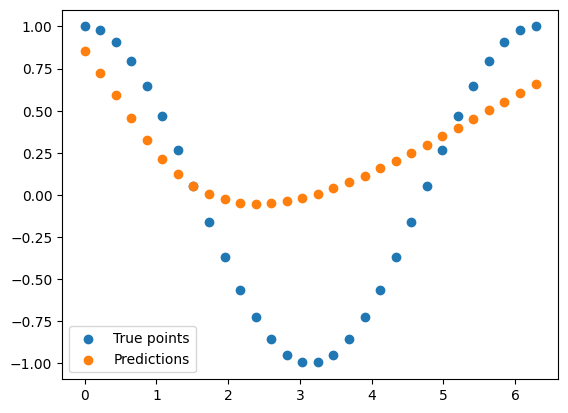

Avg loss: 0.297921 

Epoch: 14


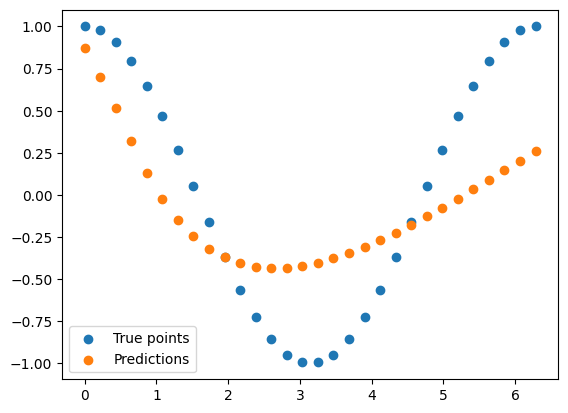

Avg loss: 0.211946 

Epoch: 15


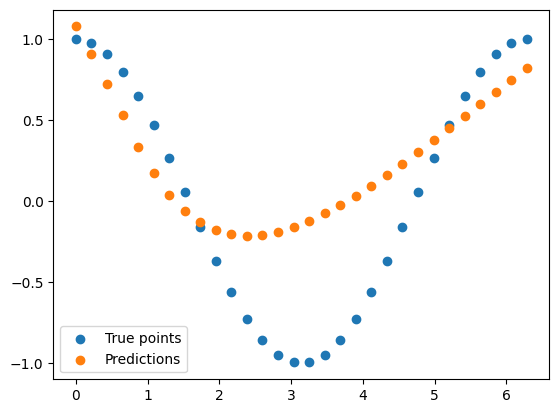

Avg loss: 0.214626 

Epoch: 40


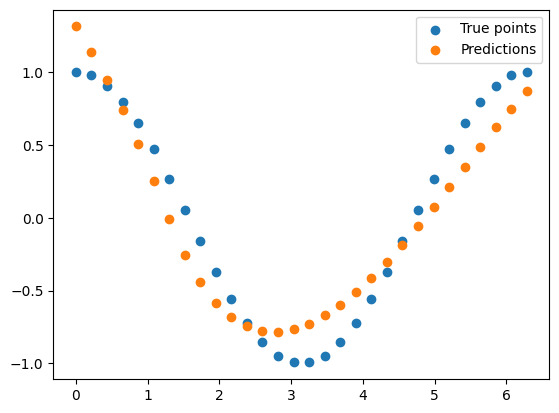

Avg loss: 0.044180 

Epoch: 80


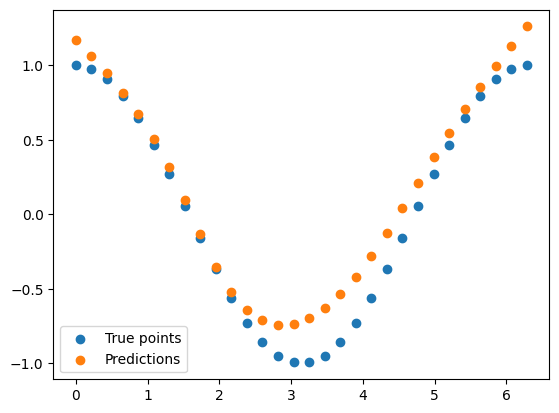

Avg loss: 0.030058 

Epoch: 120


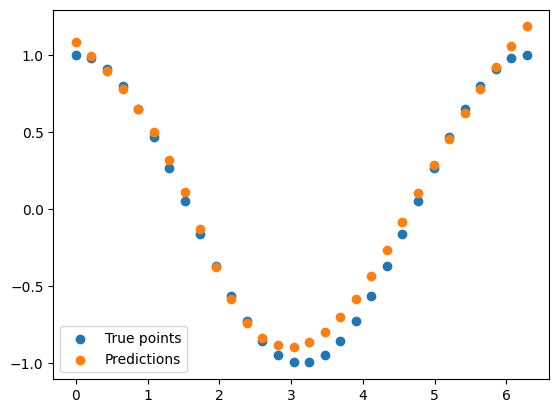

Avg loss: 0.006512 

Epoch: 160


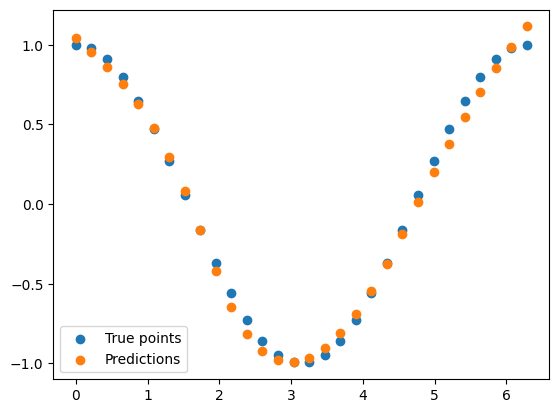

Avg loss: 0.002886 

Epoch: 200


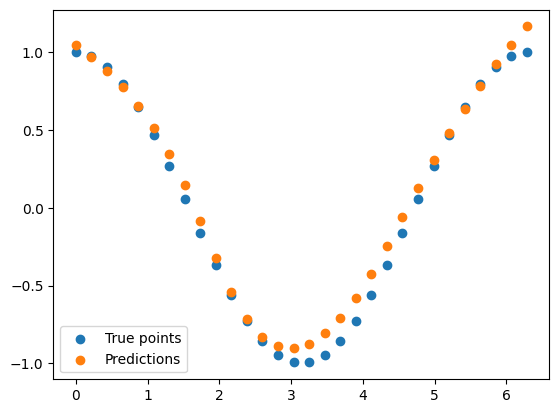

Avg loss: 0.006810 

Done!


In [19]:
training_optimizer = torch.optim.SGD(cos_precond_model.parameters(), lr=learning_rate)
cos_precond_training_losses = []
for t in range(epochs):
    
    cos_precond_training_losses.append(train_loop(cos_train_dataloader, cos_precond_model, loss_function, training_optimizer))
    if (t + 1) < 16 or (t+1) % int(.2 * epochs) == 0:
        print(f"Epoch: {t+1}")
        test_loop(cos_test_dataloader, cos_precond_model, loss_function)
print("Done!")

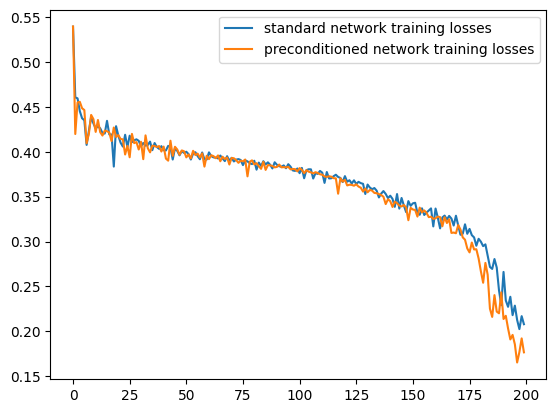

In [20]:
plt.plot(list(range(epochs)), standard_train_losses, label="standard network training losses")
plt.plot(list(range(epochs)), precond_training_losses, label="preconditioned network training losses")
plt.legend()

In [21]:
# Testing with generators
from torch import Generator
gen1 = Generator()
gen1.seed()

gen2 = Generator()
gen2.set_state(gen1.get_state())

d = FunctionDataset(torch.sin, 10)

load1 = DataLoader(d, generator=gen1, shuffle=True)
load2 = DataLoader(d, generator=gen2, shuffle=True)

for b, (X, y) in enumerate(load1):
    print(X)
print()
for b, (X, y) in enumerate(load2):
    print(X)


tensor([4.8869])
tensor([2.7925])
tensor([0.])
tensor([5.5851])
tensor([0.6981])
tensor([3.4907])
tensor([2.0944])
tensor([1.3963])
tensor([4.1888])
tensor([6.2832])

tensor([4.8869])
tensor([2.7925])
tensor([0.])
tensor([5.5851])
tensor([0.6981])
tensor([3.4907])
tensor([2.0944])
tensor([1.3963])
tensor([4.1888])
tensor([6.2832])
